In [1]:
#Changer le répertoire courant pour l'import des modules
import os

current_dir = os.getcwd()

target_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))

os.chdir(target_dir)

In [2]:
from ApplicationsUNet.loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [4]:
LS_dataset.shape, CT_dataset.shape, y_dataset.shape

((6560, 64, 64), (6560, 64, 64), (6560, 64, 64))

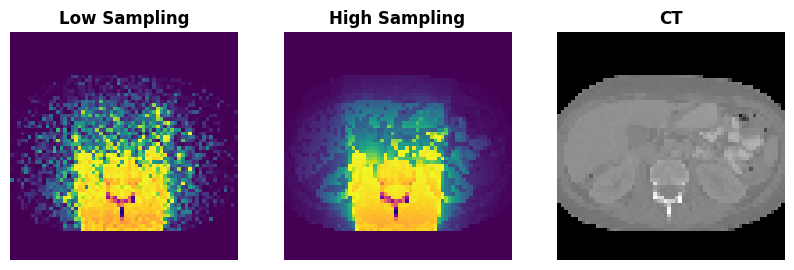

In [5]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS = LS_dataset[val_lenght,:,:]
CT = CT_dataset[val_lenght,:,:]
HS = y_dataset[val_lenght,:,:]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None, cmap=newcmp)
axes[1].set_title('High Sampling', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(CT, interpolation=None, cmap='gray')
axes[2].set_title('CT', fontweight='bold')
axes[2].axis('off')

plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    """A simplified Transformer block for integration into U-Net."""
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Self-attention
        attn_out, _ = self.self_attn(x, x, x)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # Feed-forward network
        ff_out = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        return x

# SwinTransformers Model with PyTorch

In [33]:
from einops import rearrange
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=7, shift_size=0, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size, num_heads, attn_drop, drop)
        self.drop_path = DropPath(drop) if drop > 0. else nn.Identity()

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(dim, int(dim * mlp_ratio))

    def forward(self, x, attn_mask=None):
        H, W = x.shape[1:3]
        shortcut = x
        x = self.norm1(x)
        x = rearrange(x, 'b h w c -> b (h w) c')

        # Attention layer
        x = self.attn(x, mask=attn_mask)
        x = rearrange(x, 'b (h w) c -> b h w c', h=H, w=W)
        x = shortcut + self.drop_path(x)

        # MLP layer
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut + self.drop_path(x)
        return x


class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, attn_drop, proj_drop):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads

        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            attn = attn + mask

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class UNetSwin(nn.Module):
    def __init__(self):
        super(UNetSwin, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(2, 64)
        self.trans1 = SwinTransformerBlock(dim=64, num_heads=3)
        self.enc2 = self.conv_block(64, 128)
        self.trans2 = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=512)
        self.enc3 = self.conv_block(128, 256)
        self.trans3 = TransformerBlock(embed_dim=256, num_heads=4, ff_dim=1024)
        self.enc4 = self.conv_block(256, 512)
        self.trans4 = TransformerBlock(embed_dim=512, num_heads=4, ff_dim=2048)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def conv_block(self, in_channels, out_channels):
        """Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        t1 = self.apply_transformer(c1, self.trans1)
        p1 = F.max_pool2d(t1, kernel_size=2, stride=2)
        
        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.enc4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.upconv4(bn)
        u4 = torch.cat((u4, c4), dim=1)  # Skip connection
        c5 = self.dec4(u4)
        
        u3 = self.upconv3(c5)
        u3 = torch.cat((u3, c3), dim=1)  # Skip connection
        c6 = self.dec3(u3)
        
        u2 = self.upconv2(c6)
        u2 = torch.cat((u2, c2), dim=1)  # Skip connection
        c7 = self.dec2(u2)
        
        u1 = self.upconv1(c7)
        u1 = torch.cat((u1, c1), dim=1)  # Skip connection
        c8 = self.dec1(u1)
        
        # Output
        outputs = self.output_conv(c8)
        return outputs
    
    def apply_transformer(self, x, transformer):
        """Flatten, apply transformer, and reshape back."""
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, h * w, c)  # Flatten spatial dims
        x = transformer(x)
        x = x.reshape(b, h, w, c).permute(0, 3, 1, 2)  # Restore spatial dims
        return x

In [34]:
train_lenght = int(0.70*len(LS_dataset))
val_lenght = int(0.80*len(LS_dataset))

LS_train = torch.tensor(LS_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset[:train_lenght,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[train_lenght:val_lenght,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset[train_lenght:val_lenght,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset[val_lenght:,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([4592, 2, 64, 64]),
 torch.Size([4592, 1, 64, 64]),
 torch.Size([656, 2, 64, 64]),
 torch.Size([656, 1, 64, 64]),
 torch.Size([1312, 2, 64, 64]),
 torch.Size([1312, 1, 64, 64]))

In [35]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    return np.array(all_preds)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetSwin().to(device)

criterion = nn.L1Loss()  # Loss pour le débruitage
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    evaluate_model(model, val_loader, criterion, device)

    # Vous pouvez ajouter des fonctions d'évaluation ici (sur un jeu de validation, par exemple)

torch.save(model.state_dict(), r"ApplicationsUNet\UNet LS+CT-HS\models\UNet.pth")
print("Entraînement terminé")

EinopsError:  Error while processing rearrange-reduction pattern "b h w c -> b (h w) c".
 Input tensor shape: torch.Size([10, 4096, 64]). Additional info: {}.
 Wrong shape: expected 4 dims. Received 3-dim tensor.

In [ ]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

In [ ]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\CS\AppData\Local\Temp\ipykernel_176\2359055981.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r'ApplicationsUNet\UNet LS+CT-HS\models\U

Validation Loss: 0.0042
Mean PSNR: 22.07 dB


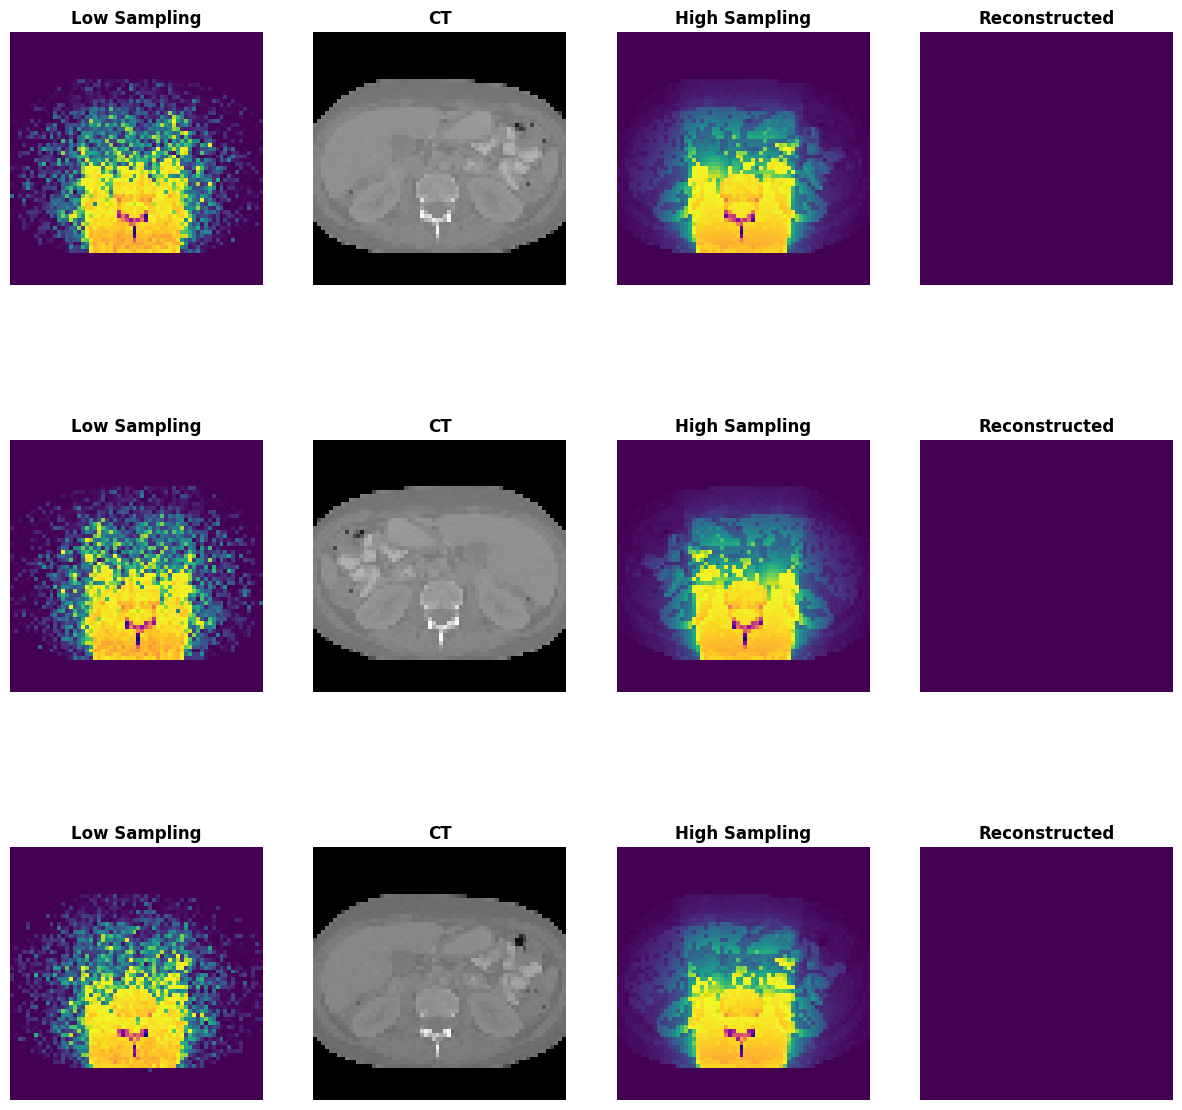

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Déplacez le modèle sur l'appareil approprié
model = UNetSwin()
checkpoint = torch.load(r'ApplicationsUNet\UNet LS+CT-HS\models\UNet.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

model.to(device)

y_pred = evaluate_model(model, test_loader, criterion, device)

x_test2 = x_test.squeeze().cpu().numpy()
y_test2 = y_test.squeeze().cpu().numpy()


fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    axes[i, 0].imshow(x_test2[i, 0], cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test2[i, 1], cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i], cmap=newcmp)
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred[i], cmap=newcmp)
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred[i]) for i in range(len(y_test))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")

In [ ]:
from swin import SwinTransformerBlock